German Traffic Sign Recognition Benchmark (GTSRB)
=================================================
---
Introduction au Deep Learning  (IDLE) - S. Aria, E. Maldonado, JL. Parouty - CNRS/SARI/DEVLOG - 2020

## Episode 4 : Data augmentation

Our main steps:
 - Increase and improve the learning dataset

## 1/ Import and init

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import h5py

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn
import os, time, random

import idle.pwk as ooo
from importlib import reload

ooo.init()

IDLE 2020 - Practical Work Module
  Version            : 0.1.4
  Run time           : Monday 13 January 2020, 21:15:42
  Matplotlib style   : idle/talk.mplstyle
  TensorFlow version : 2.0.0
  Keras version      : 2.2.4-tf


## 2/ Dataset loader
Dataset is one of the saved dataset: RGB25, RGB35, L25, L35, etc.  
First of all, we're going to use a smart dataset : **set-24x24-L**  
(with a GPU, it only takes 35'' compared to more than 5' with a CPU !)

In [11]:
%%time

def read_dataset(name):
    '''Reads h5 dataset from ./data

    Arguments:  dataset name, without .h5
    Returns:    x_train,y_train,x_test,y_test data'''
    # ---- Read dataset
    filename='./data/'+name+'.h5'
    with  h5py.File(filename) as f:
        x_train = f['x_train'][:]
        y_train = f['y_train'][:]
        x_test  = f['x_test'][:]
        y_test  = f['y_test'][:]

    # ---- done
    print('Dataset "{}" is loaded. ({:.1f} Mo)\n'.format(name,os.path.getsize(filename)/(1024*1024)))
    return x_train,y_train,x_test,y_test

Dataset "set-24x24-L-LHE" is loaded. (228.8 Mo)

CPU times: user 8 ms, sys: 132 ms, total: 140 ms
Wall time: 1.32 s


## 3/ Models
We will now build a model and train it...

This is my model ;-) 

In [37]:
# A basic model
#
def get_model_v1(lx,ly,lz):
    
    model = keras.models.Sequential()
    
    model.add( keras.layers.Conv2D(96, (3,3), activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(192, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1500, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model

# A more sophisticated model
#
def get_model_v2(lx,ly,lz):
    model = keras.models.Sequential()

    model.add( keras.layers.Conv2D(64, (3, 3), padding='same', input_shape=(lx,ly,lz), activation='relu'))
    model.add( keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add( keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(256, (3, 3), padding='same',activation='relu'))
    model.add( keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten())
    model.add( keras.layers.Dense(512, activation='relu'))
    model.add( keras.layers.Dropout(0.5))
    model.add( keras.layers.Dense(43, activation='softmax'))
    return model

# My sphisticated model, but small and fast
#
def get_model_v3(lx,ly,lz):
    model = keras.models.Sequential()
    model.add( keras.layers.Conv2D(32, (3,3),   activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1152, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model

## 4/ Callbacks  
We prepare 2 kind callbacks :  TensorBoard and Model backup

In [31]:
%%bash
# To clean old logs and saved model, run this cell
#
#/bin/rm -r ./run/logs 2>/dev/null
#/bin/rm -r ./run/models 2>/dev/null
/bin/ls -l ./run  2>/dev/null

total 8
drwxr-x--- 3 paroutyj l-simap 4096 Jan 13 21:28 logs
drwxr-x--- 2 paroutyj l-simap 4096 Jan 13 21:33 models


In [32]:
ooo.mkdir('./run/models')
ooo.mkdir('./run/logs')

# ---- Callback tensorboard
log_dir = "./run/logs/tb_" + ooo.tag_now()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# ---- Callback ModelCheckpoint - Save best model
save_dir = "./run/models/best-model.h5"
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, monitor='accuracy', save_best_only=True)

# ---- Callback ModelCheckpoint - Save model each epochs
save_dir = "./run/models/model-{epoch:04d}.h5"
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_freq=2000*5)

## 5/ Load and prepare dataset
### 5.1/ Load

In [33]:
x_train,y_train,x_test,y_test = read_dataset('set-48x48-L-LHE')

Dataset "set-48x48-L-LHE" is loaded. (913.9 Mo)



### 5.2/ Data augmentation

In [34]:
datagen = keras.preprocessing.image.ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10.)
datagen.fit(x_train)

## 5/ Train the model
**Get the shape of my data :**

In [35]:
(n,lx,ly,lz) = x_train.shape
print("Images of the dataset have this folowing shape : ",(lx,ly,lz))

Images of the dataset have this folowing shape :  (48, 48, 1)


**Get and compile a model, with the data shape :**

In [38]:
model = get_model_v3(lx,ly,lz)

# model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

**Train it :**  
Note : La courbe d'apprentissage est visible en temps réel avec Tensorboard :    
`#tensorboard --logdir ./run/logs`  

In [40]:
%%time

batch_size = 64
epochs     = 30

# ---- Shuffle train data
#x_train,y_train=ooo.shuffle_np_dataset(x_train,y_train)

# ---- Train
#
history = model.fit(  datagen.flow(x_train, y_train, batch_size=batch_size),
                      epochs=epochs,
                      verbose=1,
                      validation_data=(x_test, y_test),
                      callbacks=[tensorboard_callback, bestmodel_callback, savemodel_callback] )

model.save('./run/models/last-model.h5')

Train for 613 steps, validate on 12630 samples
Epoch 1/30
613/613 [==============================] - 14s 23ms/step - loss: 2.6682 - accuracy: 0.2347 - val_loss: 1.0431 - val_accuracy: 0.6518
Epoch 2/30
613/613 [==============================] - 12s 20ms/step - loss: 1.1481 - accuracy: 0.6272 - val_loss: 0.3927 - val_accuracy: 0.8698
Epoch 3/30
613/613 [==============================] - 13s 22ms/step - loss: 0.7645 - accuracy: 0.7480 - val_loss: 0.2486 - val_accuracy: 0.9294
Epoch 4/30
613/613 [==============================] - 13s 21ms/step - loss: 0.6177 - accuracy: 0.7999 - val_loss: 0.1862 - val_accuracy: 0.9454
Epoch 5/30
613/613 [==============================] - 12s 20ms/step - loss: 0.5352 - accuracy: 0.8278 - val_loss: 0.1689 - val_accuracy: 0.9519
Epoch 6/30
613/613 [==============================] - 14s 23ms/step - loss: 0.4701 - accuracy: 0.8480 - val_loss: 0.1500 - val_accuracy: 0.9527
Epoch 7/30
613/613 [==============================] - 13s 21ms/step - loss: 0.4300 - accu

**Evaluate it :**

In [41]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.9783


In [42]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.0812
Test accuracy  : 0.9768


## 6/ History
The return of model.fit() returns us the learning history

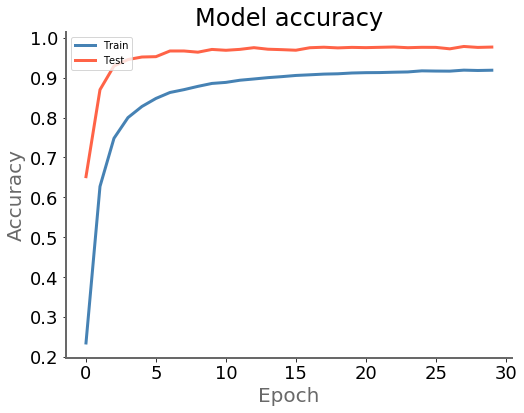

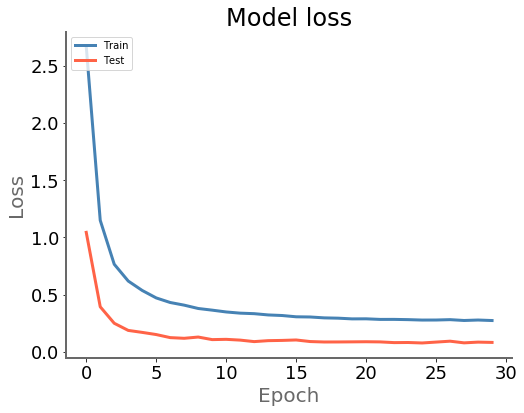

In [44]:
ooo.plot_history(history)

## 8/ Restore and evaluate best model

### 8.1/ Restore model :

In [45]:
loaded_model = tf.keras.models.load_model('./run/models/best-model.h5')
# best_model.summary()
print("Loaded.")

Loaded.


### 8.2/ Evaluate it :

In [48]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.0774
Test accuracy  : 0.9783


**Plot confusion matrix**

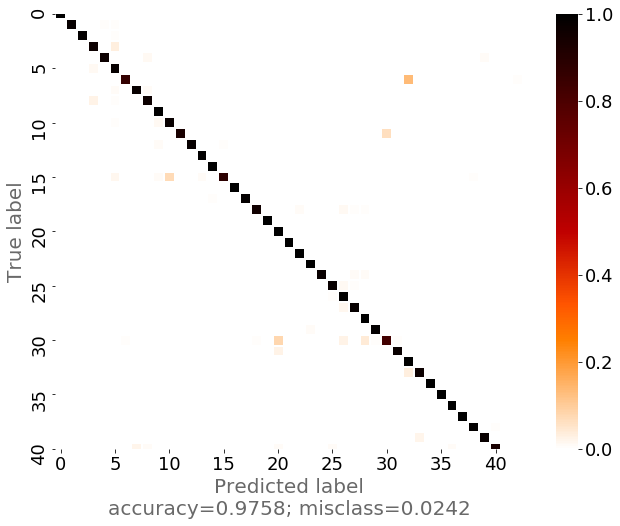

In [49]:
y_pred   = model.predict_classes(x_test)
conf_mat = confusion_matrix(y_test,y_pred, normalize="true", labels=range(43))

ooo.plot_confusion_matrix(conf_mat)

---
That's all folks !